In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import copy
eq = importr('malariaEquilibrium')
r_default_params = eq.load_parameter_set()
ages = ro.FloatVector(range(100))

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf
import arviz as az
import matplotlib.pyplot as plt

2022-12-14 11:49:35.131962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 11:49:35.569516: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def single_prev(params, eir):
    r_params = copy.deepcopy(r_default_params)
    for n, p in zip(['kb', 'ub', 'b0', 'b1', 'IB0'], params):
        r_params.rx2[n] = ro.FloatVector([p.numpy()])
    states = eq.human_equilibrium(eir, ft = 0., p=r_params, age=ages)
    return sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'pos_M')) / sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'prop'))

In [5]:
experiments = 10
kb = tfd.Gamma(4., 1.).sample(experiments)
ub = tfd.LogNormal(1., 1.).sample(experiments)
b0 = tfd.Beta(7., 1.).sample(experiments)
b1 = tfd.Beta(1., 7.).sample(experiments)
IB0 = tfd.Gamma(5., .1).sample(experiments)

2022-12-14 11:49:41.857884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 11:49:43.624526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-12-14 11:49:43.639007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [6]:
n_sites = 5
pop_sample = np.maximum(np.random.normal(size=n_sites, loc=10000, scale=1000), 0.).astype(np.float32)
EIR_sample = np.random.lognormal(1., 1., n_sites).astype(np.float32)

In [7]:
observations = np.stack([
    np.array([(single_prev([p[i] for p in [kb, ub, b0, b1, IB0]], float(EIR))) for EIR in EIR_sample])
    for i in range(experiments)
]) * pop_sample

In [8]:
model = load_model('./models/eq/')

In [9]:
default_params = pd.read_csv('default_params.csv')
bounds = pd.read_csv('./outputs/eq/bounds.csv',dtype={'name': str, 'min': np.float32, 'max': np.float32})
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
default_dict = dict(default_params.itertuples(index=False))

In [10]:
clipper = tfp.bijectors.SoftClip(bounds['min'], bounds['max'], hinge_softness=1e-10)
pop_sample_tf = tf.constant(pop_sample)

@tf.function
def model_prev(kb, ub, b0, b1, IB0, eir):
    param_shape = kb.shape
    X_ = tf.stack([
        tf.fill(param_shape, default_dict['eta']), # default age
        tf.fill(param_shape, default_dict['Q0']),
        tf.fill(param_shape, default_dict['s2']),
        tf.fill(param_shape, default_dict['rU']),
        tf.fill(param_shape, default_dict['cD']),
        tf.fill(param_shape, default_dict['g_inf']),
        tf.fill(param_shape, default_dict['cU']),
        kb,
        ub,
        tf.fill(param_shape, default_dict['uc']),
        tf.fill(param_shape, default_dict['ud']),
        tf.fill(param_shape, default_dict['kc']),
        b0,
        b1,
        IB0,
        tf.fill(param_shape, default_dict['IC0']),
        tf.fill(param_shape, default_dict['tau']),
        tf.fill(param_shape, default_dict['phi0']),
        tf.fill(param_shape, default_dict['phi1']),
        tf.fill(param_shape, default_dict['mu']),
        tf.fill(param_shape, default_dict['f']),
        tf.fill(param_shape, default_dict['fd0']),
        tf.fill(param_shape, default_dict['ad0']),
        tf.fill(param_shape, default_dict['gd'])
    ], axis=len(param_shape))
    if len(X_.shape) == 1:
        X_ = tf.expand_dims(X_, axis=0)
        eir = tf.expand_dims(eir, axis=0)
    batch_size = X_.shape[0]
    X_ = tf.repeat(X_, n_sites, axis=0)
    eir_rep = tf.reshape(eir, (batch_size * n_sites, 1))
    X = tf.concat([eir_rep, X_], axis=1)
    prev_pred = model(clipper(X))
    return tf.reshape(prev_pred, (batch_size, n_sites))

@tf.function
def prob_prev(kb, ub, b0, b1, IB0, eir):
    prev_pred = model_prev(kb, ub, b0, b1, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1,
        name='prev'
    )

In [13]:
from collections import OrderedDict
EIR_sigma = 1
sample_size = len(EIR_sample)
def bounded(x, l, u):
    return np.minimum(np.maximum(x, l), u)
EIR_guesses = bounded(EIR_sample + np.random.normal(size=len(EIR_sample), scale=EIR_sigma).astype(np.float32), 1., 100.)

joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(1., 7., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev(kb, ub, b0, b1, IB0, EIR)
    )
)

In [14]:
*prior_samples, prior_predictive = joint_dist.sample(1000).values()

2022-12-14 14:15:13.157008: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [15]:
prior_trace = az.from_dict(
    observed_data={"observations": observations[0]},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(1)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

ValueError: conflicting sizes for dimension 'observation': length 5 on the data but length 1 on coordinate 'observation'

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


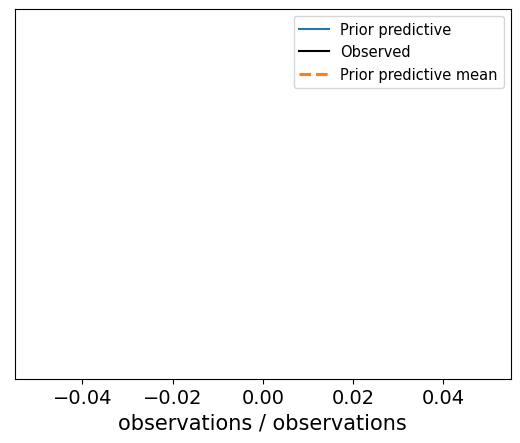

In [112]:
ax = az.plot_ppc(prior_trace, group="prior", num_pp_samples=500)

In [ ]:
#raise Error()
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(prior_keys):
            ax = axes[r][c]
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

In [151]:
log_prob(*initial_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-17.096436>

In [181]:
initial_state

[<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([6.0034566, 1.527858 , 2.225566 , 6.640756 , 1.6261125, 1.2443883,
        4.6340046, 4.22404  , 2.534739 , 3.8214633], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 0.90787923,  1.3492109 , 20.42423   ,  2.4662066 ,  3.6480134 ,
         2.947032  ,  1.0223855 ,  2.534997  ,  2.1545763 ,  6.1564636 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.65245384, 0.9321608 , 0.86194646, 0.85794175, 0.8977487 ,
        0.95067304, 0.745322  , 0.97456396, 0.83549225, 0.9654285 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.17823161, 0.11703215, 0.16113652, 0.02999024, 0.05352183,
        0.02116787, 0.16164465, 0.03285222, 0.33298093, 0.08568339],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([31.804573, 68.303795, 47.47288 , 81.08533 , 65.594055, 28.388256,
        50.1617  , 16.71387 , 28.35285 , 61.01707

In [153]:
pinned_joint_dist.experimental_default_event_space_bijector().bijectors

(<tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Exp 'exp' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>)

In [218]:
joint_dist.sample_distributions()#['prev'].log_prob(observed_prev)

(1,)
(1,)
()


(OrderedDict([('kb',
               <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float32>),
              ('ub',
               <tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>),
              ('b0',
               <tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>),
              ('b1',
               <tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>),
              ('IB0',
               <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float32>),
              ('EIR',
               <tfp.distributions.TruncatedNormal 'TruncatedNormal' batch_shape=[] event_shape=[] dtype=float32>),
              ('prev',
               <tfp.distributions.Independent 'IndependentBinomial_1' batch_shape=[] event_shape=[1] dtype=float32>)]),
 OrderedDict([('kb', <tf.Tensor: shape=(), dtype=float32, numpy=2.3918333>),
              ('ub', <tf.Tensor: shape=(), dtype=float32, 

In [220]:
joint_dist.log_prob(*initial_state, observed_prev)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-231.9674 , -229.18657, -233.9213 , -230.5714 , -229.5496 ,
       -228.62581, -230.2847 , -228.70924, -230.57799, -230.19783],
      dtype=float32)>

In [174]:
observed_prev

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[629.97546]], dtype=float32)>

In [156]:
prob_prev(*initial_state)

<tfp.distributions.Independent 'IndependentBinomial_1' batch_shape=[] event_shape=[1] dtype=float32>

In [144]:
model_prev(*initial_state)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.58377945, 0.51936364, 0.6073819 , 0.56684035, 0.5699595 ,
       0.57048476, 0.5017153 , 0.5693561 , 0.59679306, 0.5773019 ],
      dtype=float32)>

In [219]:
joint_dist.sample(value=dict(zip(parameter_names, initial_state)))

OrderedDict([('kb',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([6.0034566, 1.527858 , 2.225566 , 6.640756 , 1.6261125, 1.2443883,
                     4.6340046, 4.22404  , 2.534739 , 3.8214633], dtype=float32)>),
             ('ub',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([ 0.90787923,  1.3492109 , 20.42423   ,  2.4662066 ,  3.6480134 ,
                      2.947032  ,  1.0223855 ,  2.534997  ,  2.1545763 ,  6.1564636 ],
                    dtype=float32)>),
             ('b0',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([0.65245384, 0.9321608 , 0.86194646, 0.85794175, 0.8977487 ,
                     0.95067304, 0.745322  , 0.97456396, 0.83549225, 0.9654285 ],
                    dtype=float32)>),
             ('b1',
              <tf.Tensor: shape=(10,), dtype=float32, numpy=
              array([0.17823161, 0.11703215, 0.16113652, 0.02999024, 0.05352183,
            

In [222]:
%%time

# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

observed_prev = tf.constant(observations[0], shape=(1, 1), dtype=tf.float32)
pinned_joint_dist = joint_dist.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob(*state):
    return pinned_joint_dist.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

In [223]:
acceptance.numpy().mean()

0.0

In [224]:
parameter_names = pinned_joint_dist._flat_resolve_names()

In [231]:
posterior_predictive = tf.concat([
    list(joint_dist.sample(value=dict(zip(parameter_names, [s[:,chain,...] for s in samples]))).values())[-1][tf.newaxis, ..., tf.newaxis]
    for chain in range(num_chains)
], 0)

In [233]:
trace = az.from_dict(
    prior={k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, samples)
    },
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    posterior_predictive={"observations": posterior_predictive},
    coords={"observation": np.arange(1), "param": np.arange(len(parameter_names))},
    observed_data={"observations": observations[0]},
    dims={"observations": ["observation"], "coefficients": ["param"]},
)

print(trace)

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data


In [234]:
print(az.summary(trace).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_mean", "r_hat"]))

       mean  hdi_3%  hdi_97%         r_hat
kb    2.795   1.058    5.105  6.370274e+15
ub    2.667   0.558    9.219  8.279665e+15
b0    0.810   0.606    0.992  6.370274e+15
b1    0.109   0.009    0.259  6.370274e+15
IB0  46.376  22.719   69.870  6.370274e+15
EIR  24.742  20.616   27.484  6.370274e+15


/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


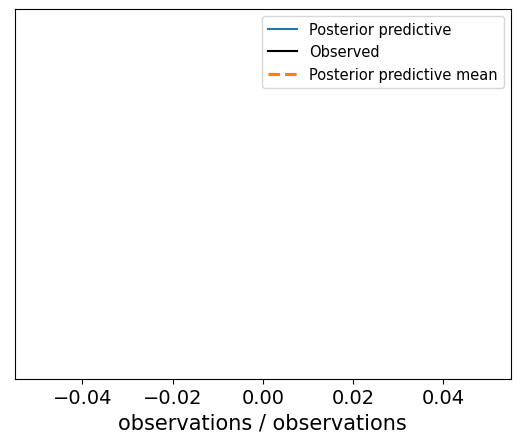

In [235]:
ax = az.plot_ppc(trace, group="posterior", num_pp_samples=500)

In [241]:
parameter_names

['kb', 'ub', 'b0', 'b1', 'IB0', 'EIR']

In [246]:
list(zip(parameter_names, (kb[0], ub[0], b0[0], b1[0], IB0[0], EIR), [s[0] for s in samples]))

[('kb',
  <tf.Tensor: shape=(), dtype=float32, numpy=5.7408967>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([1.0584987, 3.2440286, 1.7579482, 1.7050233, 2.8352141, 4.557296 ,
         3.053308 , 2.9152944, 5.104883 , 1.7152678], dtype=float32)>),
 ('ub',
  <tf.Tensor: shape=(), dtype=float32, numpy=3.4558659>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([1.6182425, 1.1977469, 2.1457686, 1.3075433, 2.5109022, 9.218931 ,
         4.372541 , 1.9168154, 0.5581054, 1.821997 ], dtype=float32)>),
 ('b0',
  <tf.Tensor: shape=(), dtype=float32, numpy=0.92058265>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.90367633, 0.8074016 , 0.9876364 , 0.60787666, 0.75683224,
         0.99164385, 0.8057847 , 0.96953446, 0.6063369 , 0.6667123 ],
        dtype=float32)>),
 ('b1',
  <tf.Tensor: shape=(), dtype=float32, numpy=0.044932567>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.09889337, 0.2572157 , 0.00917674, 0.02586895, 0.11893581,
         0.25

In [243]:
[s[0] for s in samples]

[<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1.0584987, 3.2440286, 1.7579482, 1.7050233, 2.8352141, 4.557296 ,
        3.053308 , 2.9152944, 5.104883 , 1.7152678], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1.6182425, 1.1977469, 2.1457686, 1.3075433, 2.5109022, 9.218931 ,
        4.372541 , 1.9168154, 0.5581054, 1.821997 ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.90367633, 0.8074016 , 0.9876364 , 0.60787666, 0.75683224,
        0.99164385, 0.8057847 , 0.96953446, 0.6063369 , 0.6667123 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.09889337, 0.2572157 , 0.00917674, 0.02586895, 0.11893581,
        0.25912118, 0.06817243, 0.09516143, 0.04629467, 0.10928329],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([69.87046 , 54.60536 , 34.577217, 22.718603, 34.653023, 40.41108 ,
        66.151474, 45.649944, 42.20523 , 52.915203], dtype=float32)>,
 <tf.T

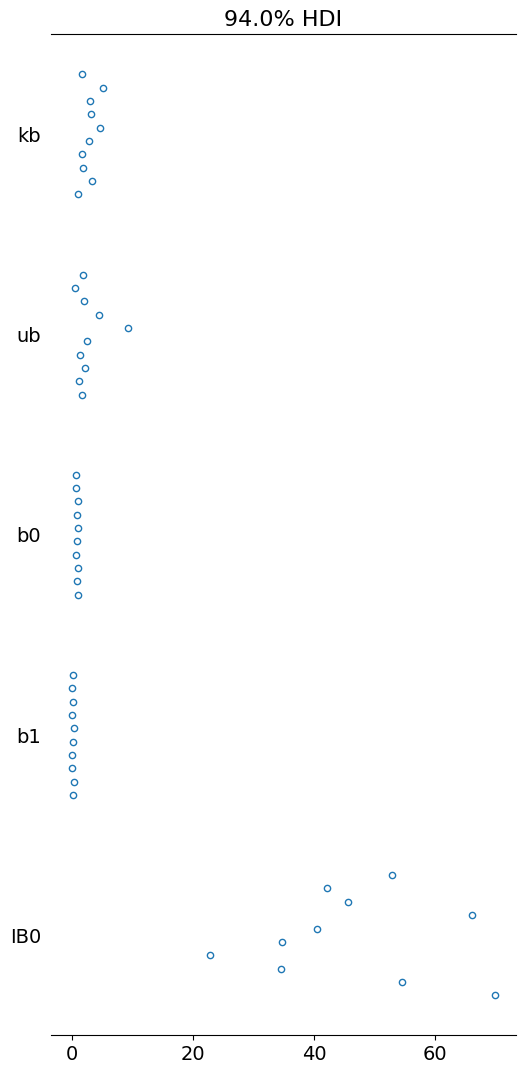

In [236]:
axs = az.plot_forest(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/gc

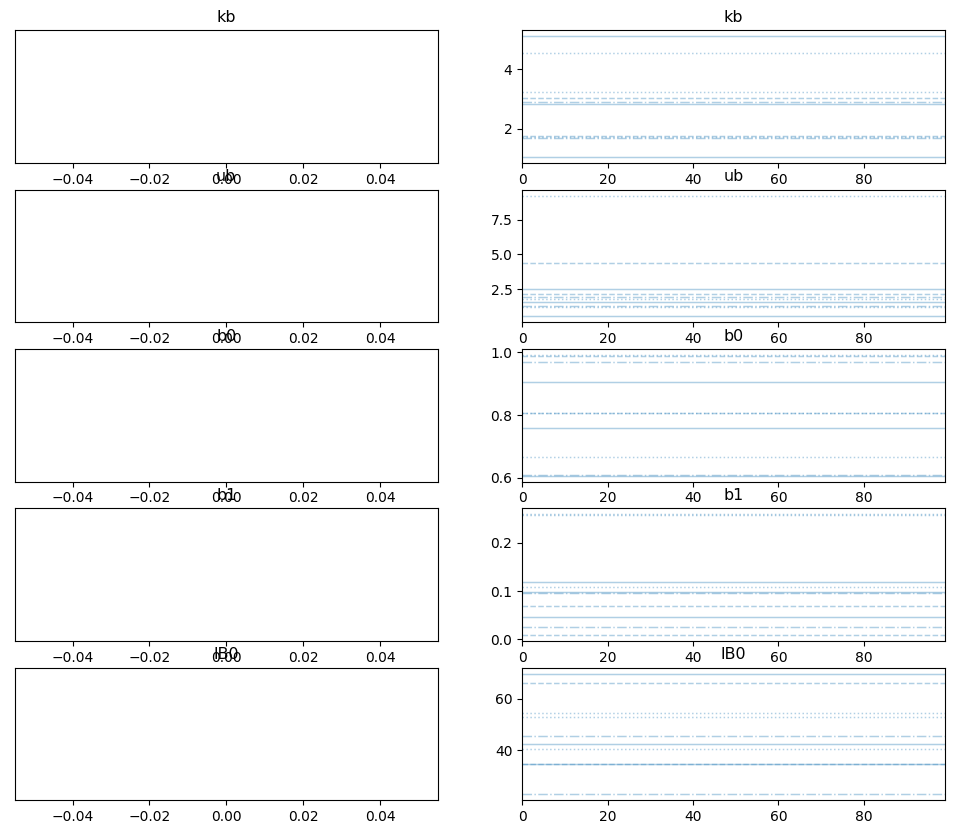

In [237]:
axs = az.plot_trace(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

In [ ]:
posterior = dict(zip(initial_state_dict.keys(), samples))

In [ ]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(posterior_keys):
            ax = axes[r][c]
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

In [ ]:
variable = 0
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            ax.plot(samples[variable][:, i:i + 1], color='red')
        else:
            fig.delaxes(ax)

In [ ]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=20)

In [ ]:
tfp.mcmc.potential_scale_reduction(samples)

In [ ]:
def single_prev(params, eir):
    states = eq.human_equilibrium(eir, ft = 0., p=params, age=ages)
    return sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'pos_M')) / sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'prop'))

def model_prev_r(kb, ub, b0, b1, IB0, eir):
    params = [kb, ub, b0, b1, IB0, eir]
    if len(kb.shape) == 0:
        return 0
        params = [tf.expand_dims(p, axis=0) for p in params]
        eir = tf.expand_dims(eir, axis=0)
    batch_size = params[0].shape[0]
    sites = eir.shape[1]
    prev = np.zeros((batch_size, sites), dtype=np.float32)
    for b in range(batch_size):
        for n, p in zip(['kb', 'ub', 'b0', 'b1', 'IB0'], params):
            batch_params = copy.deepcopy(r_default_params)
            batch_params.rx2[n] = ro.FloatVector([p[b].numpy()])
        for e_i, e in enumerate(eir[b, :]):
            prev[b, e_i] = single_prev(batch_params, ro.FloatVector([e.numpy()]))
    return prev

def prob_prev_r(kb, ub, b0, b1, IB0, eir):
    prev_pred = model_prev_r(kb, ub, b0, b1, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1
    )

In [ ]:
EIR[]

In [ ]:
p = model_prev_r(kb, ub, b0, b1, IB0, EIR)

In [ ]:
p

In [ ]:
ub

In [ ]:
joint_dist_r = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(1., 7., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev_r(kb, ub, b0, b1, IB0, EIR)
    )
)

In [ ]:
*prior_samples, prior_predictive = joint_dist_r.sample(1000).values()

In [ ]:
prior_trace_r = az.from_dict(
    observed_data={"observations": pop_sample * prev_sample},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(sample_size)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

In [ ]:
ax = az.plot_ppc(prior_trace_r, group="prior", num_pp_samples=500)

In [ ]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

pinned_joint_dist_r = joint_dist_r.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist_r.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob_r(*state):
    return pinned_joint_dist_r.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob_r,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist_r.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

In [ ]:
samples